<a href="https://colab.research.google.com/github/mezaga/ACIML/blob/aciml-06%2F10%2F22/ACIML_seminario_prototype_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ACIML Prototipo**

Gerardo Meza, UNAM





---

DESCARGA DE AUDIOS:
https://drive.google.com/file/d/1KW_QrFYsts3ccMv222hJsOLWHKCPdCb_/view?usp=sharing


In [28]:
#@title Carga de Librerias
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1P--SbiazyeD_m3Nxhuz331knZ2B-iWZO' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1P--SbiazyeD_m3Nxhuz331knZ2B-iWZO" -O encoder2_cdmx.zip && rm -rf /tmp/cookies.txt
!unzip /content/encoder2_cdmx.zip
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=169SFhtDzPuoM0d5YzIdRVjx3C-8dSB7o' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=169SFhtDzPuoM0d5YzIdRVjx3C-8dSB7o" -O decoder2_cdmx.zip && rm -rf /tmp/cookies.txt
!unzip /content/decoder2_cdmx.zip

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1egipBGfxnvWiDE4C0wgr2uO2-xfK3t3R' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1egipBGfxnvWiDE4C0wgr2uO2-xfK3t3R" -O vanilla_encoder.zip && rm -rf /tmp/cookies.txt
!unzip /content/vanilla_encoder.zip
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=12XmcSvVEsn3Fdg-SoCGxQGZdKQTSHeDU' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=12XmcSvVEsn3Fdg-SoCGxQGZdKQTSHeDU" -O vanilla_decoder.zip && rm -rf /tmp/cookies.txt
!unzip /content/vanilla_decoder.zip
from scipy.signal import butter, filtfilt
from scipy import signal
import math
from scipy.signal import butter, sosfilt, sosfreqz
from sklearn.preprocessing import StandardScaler
from ipywidgets import HBox, VBox
import ipywidgets as widgets
from ipywidgets import TwoByTwoLayout
from ipywidgets import interact, interactive, fixed, interact_manual
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import IPython
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras import layers
from keras.models import Model
from keras import backend as K
from sklearn.decomposition import  PCA
from mpl_toolkits.mplot3d import Axes3D
import IPython
import pickle
import pandas as pd
import random
sr16k = 16000
AUDIO_LOAD = []
etiquetas = []
track_num = []

def normalize_sum(values):
  env_val = np.array([x.value for x in values])
  env_val = env_val/ env_val.min()
  env_val = env_val/env_val.sum()
  return env_val
  
def sinusoid(freq=440.0, dur=1.0, srate=16000, amp=1.0, phase = 0.0): 
    t = np.linspace(0,dur,int(srate*dur))
    data = amp * np.sin(2*np.pi*freq *t+phase)
    return data

def envelope(atk,dcy,susTime,rel, durs, sr):
 env = np.concatenate((np.linspace(0,atk,int(durs[0]*sr//1)), np.linspace(atk,dcy, int(durs[1]*sr//1)), np.linspace(susTime,susTime, int(durs[2]*sr//1)),np.linspace(susTime,0, int(durs[3]*sr//1))),axis = None)
 if env.shape[0] < sr:
   env = np.concatenate((env,np.zeros(sr - env.shape[0])))
 return env

class SynthGen:
  """This class returns a synth"""
  def __init__(self, sr , envelope):
    self.sr = sr
    #self.osc = osc
    self.env = envelope
    
   ######aun hay que arreglar que carge la carga de la señal 
   
  def sinusoid(self, freq = 100, dur=1.0, amp= 1.0, phase = 0.0): 
    t = np.linspace(0,dur,int( self.sr * dur))
    osc = amp * np.sin(2*np.pi* freq * t + phase)
    return osc

  def am(self, c_freq= 100.0, m_freq = 10.0, dur = 1):
    sig = sinusoid(c_freq,dur) * sinusoid(m_freq, dur)
    return sig * self.env

  def fm(self, c_freq = 100, mod_freq = 10, index_mod = 3, dur = 1):
    carrier = sinusoid(c_freq, dur, 1)
    mod = index_mod * sinusoid(mod_freq, dur)
    sig = np.cos(carrier + mod)
    return sig * self.env

  def fm(self, c_freq = 100, mod_freq = 10, index_mod = 3, dur = 1):
    carrier = sinusoid(c_freq, dur, 1)
    mod = index_mod * sinusoid(mod_freq, dur)
    sig = np.cos(carrier + mod)
    return sig * self.env
  
  def additive(self, freq = 100, dur= 1, amplist= []):
    i = 1
    t = np.linspace(0, dur, math.ceil(self.sr * dur))
    ### initialize a new output
    sig = np.zeros(t.size)
    for num in amplist:
        x = np.multiply(sinusoid(freq * i, dur), num)
        ### sum it to the output
        sig = sig + x
        i+=1
    ### making sure the maximum amplitude does not exeed 1
    if np.max(sig)>abs(np.min(sig)):
        sig = sig / np.max(sig)
    else:
        sig = sig / -np.min(sig)
    return sig * self.env
  
  def sustractive(self, lowcut= 800, highcut = 1000):
    
    def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

    def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
            sos = butter_bandpass(lowcut, highcut, fs, order=order)
            y = sosfilt(sos, data)
            return y
        
    num_samples = self.sr
    sig = np.random.rand(num_samples) * 2 - 1
    sig = butter_bandpass_filter(sig, lowcut, highcut, num_samples)
    
    return sig

envdict= {'atk': [0,1.], 'dcy': [0,1.], 'susTime': [0,1.], 'rel': [0,1.]}
am_param = {'carrier_freq': [20,8000],'mod_freq':[20,8000]}
AUDIO_LOAD = []
def random_val(val_1, size = 1):
  val = sorted(val_1)
  result = np.random.randint(val[0], val[1], size)[0]
  return result

env = [widgets.FloatSlider(value= 0.5, min=envdict[key][0], max=envdict[key][1], step=0.01, description= key,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout= False,
    readout_format='d',
)for key in envdict.keys()]

envdur = [widgets.FloatSlider(value= 0.5, min=envdict[key][0], max=envdict[key][1], step= 0.01, description= key+'dur',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout= False,
    readout_format='d',
)for key in envdict.keys()]

am = [widgets.IntRangeSlider(value=[4000,8000], min=am_param[key][0], max=am_param[key][1], step= 10, description= key,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)for key in am_param.keys()]

gen = [widgets.BoundedIntText(value=7, min=0, max=10,step=1,description='AMOUNT:',disabled=False),
       widgets.Text(value='Synth', placeholder='Type something', description='group_id:', disabled=False)
]

button = widgets.Button(
    description='Generate',
)

tab1 = HBox(children = [VBox(children= env),
                        VBox(children= envdur),
                        VBox(children= am) ,
                        VBox(children= gen),
                        VBox(children = [button])])
                        
tab2 = HBox(children = [VBox(children= env),VBox(children= env) ,VBox(children= env)])
tab3 = HBox(children = [VBox(children= env),VBox(children= env) ,VBox(children= env)])
tab4 = HBox(children = [VBox(children= env),VBox(children= env) ,VBox(children= env)])


tab2 = VBox(children=[widgets.IntRangeSlider(
    value=[5, 7],
    min=0,
    max=10,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)])

AM = []

@button.on_click
def boton_action(b=None):
  for i in range(gen[0].value):
    ####las envolventes no están por rangos
    norm_envelope = normalize_sum(envdur)
    z = envelope(env[0].value,env[1].value, env[2].value, env[3].value, norm_envelope, 16000 * 1)
    synth = SynthGen(sr16k, z)
    data = synth.am(random_val(am[0].value),random_val(am[1].value), 1)
    fft = librosa.amplitude_to_db(np.abs(np.fft.fft(data)))
    f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
    #AUDIO_LOAD.append({'gid': text,'id': text+ str(idx), 'trackname': track, 'data': data, 'fft': fft, 'f0': f0})
    AUDIO_LOAD.append({'gid': gen[1].value,'id': gen[1].value + str(i), 'trackname': gen[1].value + str(i) + '.wav','data': data, 'fft': fft, 'f0': f0})

tab = widgets.Tab()
tab.children = [tab1,tab2,tab3,tab4]
tab.set_title(0," amplitude mod")
tab.set_title(1,"fm")
tab.set_title(2,"additive")
tab.set_title(3,"sustractive")


 


--2022-11-13 02:21:52--  https://docs.google.com/uc?export=download&confirm=t&id=1P--SbiazyeD_m3Nxhuz331knZ2B-iWZO
Resolving docs.google.com (docs.google.com)... 142.251.10.101, 142.251.10.138, 142.251.10.100, ...
Connecting to docs.google.com (docs.google.com)|142.251.10.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f4d8cngv4470580nb1obk5j56lqnlbss/1668306075000/00101780325229425041/*/1P--SbiazyeD_m3Nxhuz331knZ2B-iWZO?e=download&uuid=772207df-9498-4f18-92f0-b1b83084c3ce [following]
--2022-11-13 02:21:53--  https://doc-0c-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f4d8cngv4470580nb1obk5j56lqnlbss/1668306075000/00101780325229425041/*/1P--SbiazyeD_m3Nxhuz331knZ2B-iWZO?e=download&uuid=772207df-9498-4f18-92f0-b1b83084c3ce
Resolving doc-0c-58-docs.googleusercontent.com (doc-0c-58-docs.googleusercontent.com)... 142.251.10.132, 

# En la siguente celda puedes subir tus archivos.
1. Escoge el nombre del grupo de audios.
2. Evalúa la celda.
3. Repite hasta tener todos los conjuntos que necesites

In [30]:
#@title Carga de audios { run: "auto" }
## 

from google.colab import files

dropdown = 'Subir archivos' #@param ["Subir archivos", "crear", "grabar"]
if dropdown == 'Subir archivos':
  text = [widgets.Text(value='Synth', placeholder='Type something', description='group_id:', disabled=False)
]

  load = HBox(children= text)
  display(load)
  sr16k = 16000
  secs = 1
  uploaded = files.upload()
#track_num.append(len(uploaded))
  for idx, track in enumerate(uploaded.keys()):
    print(track)
    if track.endswith("wav"):
        SR = librosa.get_samplerate(track)
        y, fs = librosa.load(track, SR)
        data = librosa.resample(y[:SR * secs], orig_sr= SR, target_sr= sr16k)
        ##features (tenemos que arreglar el fft apara que sean valores de amp)
        fft = librosa.amplitude_to_db(np.abs(np.fft.fft(data)))
        f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
      #takes only 1 sec and resample to 16k 
        etiquetas.append(text[0].value)
        AUDIO_LOAD.append({'gid': text[0].value,'id': text[0].value + str(idx), 'trackname': track, 'data': data, 'fft': fft, 'f0': f0})
  
if dropdown ==  'crear': 
  #print('efkwjefwkf')
  display(tab)

if dropdown == 'grabar':
  pass

Saving am_054.wav to am_054 (1).wav
Saving am_056.wav to am_056 (1).wav
Saving am_057.wav to am_057 (1).wav
am_054.wav
am_056.wav
am_057.wav


In [ ]:
#@title Carga de audios
## 

from google.colab import files
#@ tectInserta
text = 'am' #@param {type:"string"}
#AUDIO_LOAD = []
sr16k = 16000
secs = 1
uploaded = files.upload()
#track_num.append(len(uploaded))
for idx, track in enumerate(uploaded.keys()):
  print(track)
  if track.endswith("wav"):
      SR = librosa.get_samplerate(track)
      y, fs = librosa.load(track, SR)
      data = librosa.resample(y[:SR * secs], orig_sr= SR, target_sr= sr16k)
      ##features (tenemos que arreglar el fft apara que sean valores de amp)
      fft = librosa.amplitude_to_db(np.abs(np.fft.fft(data)))
      f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
    #takes only 1 sec and resample to 16k 
      etiquetas.append(text)
      AUDIO_LOAD.append({'gid': text,'id': text+ str(idx), 'trackname': track, 'data': data, 'fft': fft, 'f0': f0})
      

Saving am_048.wav to am_048.wav
Saving am_049.wav to am_049.wav
Saving am_050.wav to am_050.wav
Saving am_051.wav to am_051.wav
Saving am_052.wav to am_052.wav
am_048.wav
am_049.wav
am_050.wav
am_051.wav
am_052.wav


En la siguiente celda podrás visualizar una tabla con múltiples características que los describen.

In [31]:
#@title DATASET

DATA = pd.DataFrame(AUDIO_LOAD)
#PCA 
data_fft = np.vstack(DATA['fft'])
mu_fft = np.mean(data_fft, axis= 0)
s_fft = np.std(data_fft, axis = 0)+ 0.000001
Xmu_FFT = data_fft- mu_fft/s_fft
DATA

,gid,id,trackname,data,fft,f0
0,crear,crear0,crear0.wav,"[0.0, 5.274631861175652e-05, 1.190409960815590...","[-16.755273931686148, -16.755273931686148, -16...",313.719165
1,crear,crear1,crear1.wav,"[0.0, 2.44182572525524e-05, 0.0001494594706941...","[-16.496216441980096, -16.496216441980096, -16...",351.583291
2,crear,crear2,crear2.wav,"[0.0, 6.450731193742302e-05, 0.000249785781300...","[-16.47819494830359, 3.016781109425168, 9.1697...",2038.215576
3,crear,crear3,crear3.wav,"[0.0, 0.00012209623619441502, 2.08789998950178...","[-16.479167484269574, -16.479167484269574, -16...",172.085741
4,crear,crear4,crear4.wav,"[0.0, 1.1083714048001788e-05, 7.97977496410842...","[-16.48335204289873, -16.48335204289873, -16.4...",396.945177
5,crear,crear5,crear5.wav,"[0.0, 1.759323710536941e-05, 1.040102579084800...","[-16.89645382142828, -16.89645382142828, -16.8...",693.685499
6,crear,crear6,crear6.wav,"[0.0, 2.9267133418893097e-05, 0.00010613176611...","[-16.628074704000383, -16.628074704000383, -16...",689.420794
7,Synth,Synth0,am_054.wav,"[-0.056399234, -0.09583528, -0.088743076, -0.0...","[0.9758335314684431, -1.5113486403984069, -7.2...",123.808474
8,Synth,Synth1,am_056.wav,"[-0.014646156, -0.022202875, -0.016864514, -0....","[-8.29522576413326, -8.641160200175538, -10.13...",89.802148
9,Synth,Synth2,am_057.wav,"[-2.852458e-06, -1.2620625e-05, -2.1810978e-05...","[-9.246675465916308, -9.164591829079956, -9.17...",52.954908


In [32]:
#@title Filtrado
zliders = dict(DATA['gid'].value_counts())
color = list(np.random.choice(np.random.randint(0,30),len(zliders),replace = False))
sliders = []
for key in zliders.keys():
  sliders.append(widgets.IntSlider(value = zliders[key], max= zliders[key], step = 1, description= key))

update_sliders = dict(zip([x for x in zliders], sliders))

ui = widgets.VBox(sliders)

def datafilter(**kwargs):
  '''update n number of sliders corresponding to dataclases by splitting dataset uin subgroups and joining them again'''
  dframes = []
  for key, value in kwargs.items():
    dframes.append(DATA[DATA['gid'] == key].reset_index().iloc[0: value])
    #print(key + str(value))
  DATA_filt = pd.concat(dframes).reset_index()
  print(DATA_filt['gid'])
  return DATA_filt


out = widgets.interactive_output(datafilter, update_sliders)
updated_df = datafilter
display(ui,out)

Output()

In [33]:
#@title DATASET
dframes = []
for key, value in update_sliders.items():
  dframes.append(DATA[DATA['gid'] == key].reset_index().iloc[0: value.value])
  #print(key + str(value))
  DATA_filt = pd.concat(dframes).reset_index()
audiotracks = dict(zip(DATA_filt['id'],DATA_filt['id'].index))
DATA_filt

,level_0,index,gid,id,trackname,data,fft,f0
0,0,0,crear,crear0,crear0.wav,"[0.0, 5.274631861175652e-05, 1.190409960815590...","[-16.755273931686148, -16.755273931686148, -16...",313.719165
1,1,1,crear,crear1,crear1.wav,"[0.0, 2.44182572525524e-05, 0.0001494594706941...","[-16.496216441980096, -16.496216441980096, -16...",351.583291
2,2,2,crear,crear2,crear2.wav,"[0.0, 6.450731193742302e-05, 0.000249785781300...","[-16.47819494830359, 3.016781109425168, 9.1697...",2038.215576
3,3,3,crear,crear3,crear3.wav,"[0.0, 0.00012209623619441502, 2.08789998950178...","[-16.479167484269574, -16.479167484269574, -16...",172.085741
4,4,4,crear,crear4,crear4.wav,"[0.0, 1.1083714048001788e-05, 7.97977496410842...","[-16.48335204289873, -16.48335204289873, -16.4...",396.945177
5,5,5,crear,crear5,crear5.wav,"[0.0, 1.759323710536941e-05, 1.040102579084800...","[-16.89645382142828, -16.89645382142828, -16.8...",693.685499
6,6,6,crear,crear6,crear6.wav,"[0.0, 2.9267133418893097e-05, 0.00010613176611...","[-16.628074704000383, -16.628074704000383, -16...",689.420794
7,0,7,Synth,Synth0,am_054.wav,"[-0.056399234, -0.09583528, -0.088743076, -0.0...","[0.9758335314684431, -1.5113486403984069, -7.2...",123.808474
8,1,8,Synth,Synth1,am_056.wav,"[-0.014646156, -0.022202875, -0.016864514, -0....","[-8.29522576413326, -8.641160200175538, -10.13...",89.802148
9,2,9,Synth,Synth2,am_057.wav,"[-2.852458e-06, -1.2620625e-05, -2.1810978e-05...","[-9.246675465916308, -9.164591829079956, -9.17...",52.954908


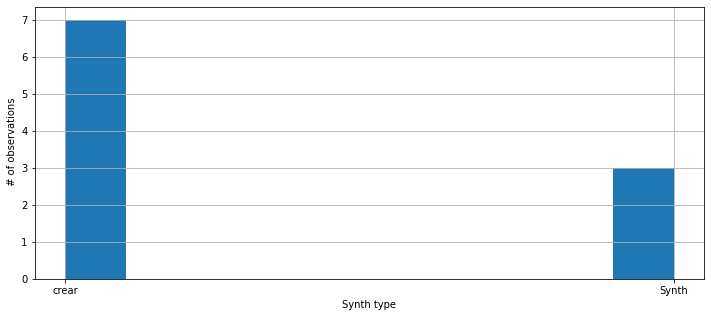

In [35]:
#@title Visualización de datos { run: "auto" }
ids = list(DATA_filt['id'])
audio_viz = 'histogram' #@param ['PCA','F0', 'histogram','spectrogram']
#fig, ax = plt.subplots()
plt.figure(figsize = [12,5])
#fig.set_size_inches([12,5])

if audio_viz == 'histogram':
  ax = plt.subplot(1,1,1)
  ax = DATA_filt['gid'].hist()
  ax.set_xlabel("Synth type")
  ax.set_ylabel(" # of observations")
  plt.show()
if audio_viz == 'F0':
  ax = plt.subplot(1,1,1)
  ax.set_xlabel("Audios")
  ax.set_ylabel(" F0")
  ax.plot(DATA_filt.index, DATA_filt['f0'], linestyle = '--')
  #plt.show()
if audio_viz == 'PCA':
  ax = plt.subplot(1,1,1)
  pca = PCA(n_components= 2)
  X_PCA = pca.fit_transform(Xmu_FFT)
  print('variance: ')
  print(pca.explained_variance_ratio_)
  counter = 0 
  cu = 0

  for key, value in zliders.items():
    #print(key,value)
    ax.scatter(X_PCA[counter: counter + value, 0], X_PCA[counter: counter + value, 1], cmap= 10, label = key)
    counter += value
    cu += 1
  ax.set_title('PCA')
  ax.set_xlabel('PCA 1')
  ax.set_ylabel('PCA 2')
  ax.legend()

if audio_viz == 'spectrogram':
  z = DATA_filt['fft'].sample(3)
  for i, x in enumerate(z):
    ax = plt.subplot(1, 3, i + 1)
    stft = librosa.stft(x)#, n_fft=512, hop_length= (512-1)//2)
    stft = librosa.amplitude_to_db(np.abs(stft),ref=np.max)
    librosa.display.specshow(stft,sr = 16000, y_axis='fft_note', x_axis='time')
    ax.set_title('spectrogram_'+ str(i))
    #ax.set_set_xlabel('time')
  #for idx, id in enumerate(ids):
  #  ax.annotate(id,(X_PCA[idx][0], X_PCA[idx][1]+ 0.2))
  #fig.add_axes(ax)
  
  plt.show()
  


In [36]:
#@title Entrenamiento del modelo

from google.colab import files
##standarizacion de datos
data = np.vstack(DATA_filt['data'])
mu_wave = np.mean(data, axis= 1)[...,np.newaxis]
max_wave = np.max(data, axis=1)[...,np.newaxis]
Xw = (data- mu_wave)/max_wave
Xw = Xw[...,np.newaxis][...,np.newaxis]

referencia_1 = 'Preentrenado' #@param ['Nuevo modelo','Preentrenado','mi modelo']
Epocas = 39 #@param {type:"slider", min:10, max:10000, step:1}
batches = 5 #@param {type: "integer"}
lr = 0.00008 #@param {type: "slider", min:0.00001, max: 0.0001, step:0.00001}

warm_up_iters = 1000 
optimizer = tf.keras.optimizers.Adam(lr, clipvalue=0.5)
if referencia_1 == 'Preentrenado': 
  original_dim = (16000, 1, 1)
  encoder_inputs = keras.Input(original_dim)  
  encoder_pretrained = tf.keras.models.load_model('/content/encoder2_cdmx',compile = False)
  decoder_pretrained = tf.keras.models.load_model('/content/decoder2_cdmx',compile = False)
  outpt = decoder_pretrained(encoder_pretrained(encoder_inputs)[2])
  vae = Model(inputs=encoder_inputs, outputs=outpt, name='VAE-Model')
  vae.compile(optimizer= optimizer,loss = 'mean_squared_error')
  tr_logs = vae.fit(Xw, Xw, shuffle = True, batch_size= batches, epochs= Epocas, verbose = 1)
  latent =  encoder_pretrained.predict(Xw[0:])

if referencia_1 == 'Nuevo modelo': 
  original_dim = (16000, 1, 1)
  encoder_inputs = keras.Input(original_dim)  
  encoder_pretrained = tf.keras.models.load_model('/content/vanilla_encoder',compile = False)
  decoder_pretrained = tf.keras.models.load_model('/content/vanilla_decoder',compile = False)
  outpt = decoder_pretrained(encoder_pretrained(encoder_inputs)[2])
  vae = Model(inputs= encoder_inputs, outputs= outpt, name='VAE-Model')
  vae.compile(optimizer= optimizer,loss = 'mean_squared_error')
  tr_logs = vae.fit(Xw, Xw, shuffle = True, batch_size= batches, epochs= Epocas, verbose = 1)
  latent =  encoder_pretrained.predict(Xw[0:])
else:
  print('.....')
  '''
  new_model = tf.keras.models.load_model('/content/model_vae')
  new_model.compile(optimizer= optimizer,loss = 'mean_squared_error')
  tr_logs = new_model.fit(Xw, Xw, shuffle = True, batch_size= batches, epochs= Epocas, verbose = 1)
  '''


Epoch 1/39
2/2 [==============================] - 1s 67ms/step - loss: 0.1533
Epoch 2/39
2/2 [==============================] - 0s 44ms/step - loss: 0.1341
Epoch 3/39
2/2 [==============================] - 0s 38ms/step - loss: 0.1248
Epoch 4/39
2/2 [==============================] - 0s 37ms/step - loss: 0.1197
Epoch 5/39
2/2 [==============================] - 0s 39ms/step - loss: 0.1157
Epoch 6/39
2/2 [==============================] - 0s 38ms/step - loss: 0.1132
Epoch 7/39
2/2 [==============================] - 0s 38ms/step - loss: 0.1104
Epoch 8/39
2/2 [==============================] - 0s 38ms/step - loss: 0.1076
Epoch 9/39
2/2 [==============================] - 0s 37ms/step - loss: 0.1047
Epoch 10/39
2/2 [==============================] - 0s 37ms/step - loss: 0.1021
Epoch 11/39
2/2 [==============================] - 0s 36ms/step - loss: 0.0998
Epoch 12/39
2/2 [==============================] - 0s 36ms/step - loss: 0.0973
Epoch 13/39
2/2 [==============================] - 0s 38ms/st

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 14ms/step


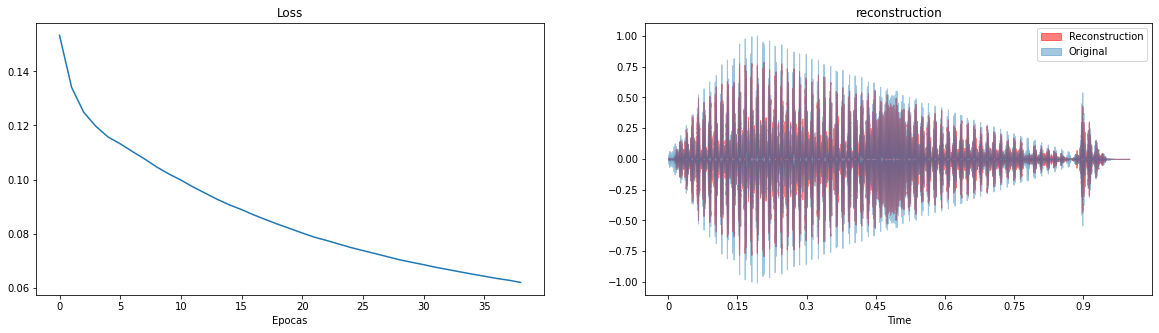

In [37]:
#@title Evaluación del modelo
#una visualización donde se vea la curva del modelo junto a la recunstruccion

def latent_vectorize(audio_id,df,audio_list):
  audio_idx = list(df[df['id'] == audio_id].index)[0]
  latent_gen = encoder_pretrained.predict(audio_list[audio_idx:])
  return latent_gen[0]

def latent_reconstruction(latent_gen):
  recons = decoder_pretrained.predict(latent_gen[0:])
  recons= recons[0].flatten()
  return recons


def latent_search(audio_id, df, audio_list):
  '''function that retrieves the correct audio representation in the latent space'''
  try:
    latent_gen = latent_vectorize(audio_id,df,audio_list)
    recons = latent_reconstruction(latent_gen)
    return latent_gen, recons
  except TypeError:
    print("audio input must be a valid string")
    
def latent_inter(audio_a, audio_b, step = 100, porcentaje = 50, audio_list = Xw):
  'crea 100 vectores pensados en % y reconstruye'
  if step == 1:
    listas = np.linspace(audio_a, audio_b, step)
    res = latent_reconstruction(listas[porcentaje-1:])
  else:
    listas = np.linspace(audio_a, audio_b, step)
    res = latent_reconstruction(listas[porcentaje-1:])
  return res

'''
def latent_search(audio_id, df, audio_list):
 ''''''function that retrieves the correct audio representation in the latent space''''''
  try:
    audio_idx = list(df[df['id'] == audio_id].index)[0]
    latent_gen = encoder_pretrained.predict(audio_list[audio_idx:])
    recons = decoder_pretrained.predict(latent_gen[0][0:])
    recons= recons[0].flatten()
    return latent_gen, recons
  except TypeError:
    print("audio input must be a valid string")
'''

def gps_latent(dic_tracks, df, data):
  '''search all track ids position in the latent space in an ''orderly fashion'' '''
  res_latent = []
  for key in dic_tracks.keys():
    res_latent.append(latent_search(key, df, data)[0])
  return res_latent

all_tracks_latent = gps_latent(audiotracks, DATA_filt, Xw)



track = random.choices(ids)[0]
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)
fig.set_figheight(5)
ax[0].plot(tr_logs.history['loss'])
librosa.display.waveshow(latent_search(track, DATA_filt, Xw)[1], sr=16000, color='r', alpha=0.5, ax=ax[1], label='Reconstruction')
librosa.display.waveshow(Xw[audiotracks[track]].flatten(), sr=16000, alpha=0.4, ax=ax[1], label='Original')
ax[1].legend()
ax[0].set_xlabel("Epocas")
ax[0].set_title('Loss')
ax[1].set_title('reconstruction')


####archivos de audio
IPython.display.display(IPython.display.Audio(Xw[audiotracks[track]].flatten(), rate = sr16k))
IPython.display.display(IPython.display.Audio(latent_search(track, DATA_filt, Xw)[1],rate = sr16k))

1/1 [==============================] - 0s 15ms/step


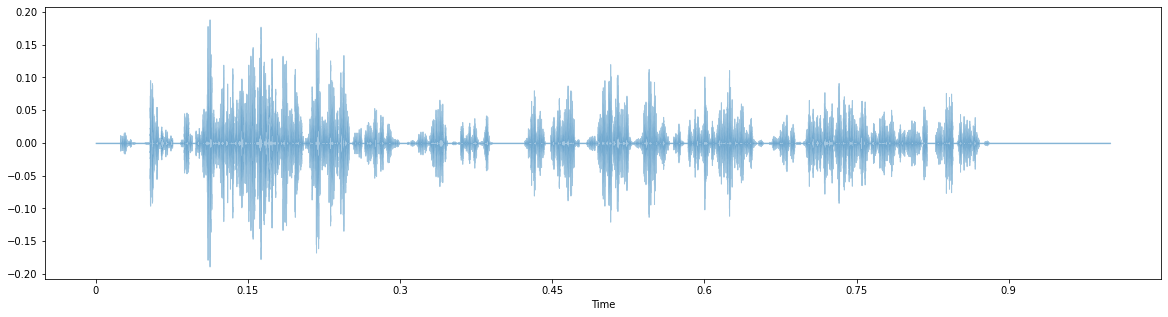

In [25]:
#@title Exploración y generación { run: "auto" }
audio_id = 'Synth0' #@param {type:"string"}
audio_id2 = '_1' #@param {type:"string"}

porcentaje_de_cambio = 2 #@param {type:"slider", min:1, max:10, step:1}
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(5)

idx = list(DATA_filt[DATA_filt['id'] == audio_id].index)[0]
idx2 = list(DATA_filt[DATA_filt['id'] == audio_id2].index)[0]
audio_a = all_tracks_latent[0][idx]
audio_b = all_tracks_latent[0][idx2]
inter = latent_inter(audio_a, audio_b, 10, porcentaje_de_cambio)

#a_1 = latent_search(audio)[0]
#a_2 = latent_search(audio)[0]

#inter = latent_inter(a_1,a_2, 100, porcentaje_de_cambio)
#ax.plot(inter)
librosa.display.waveshow(inter, sr=16000, alpha=0.4, label='Original')
IPython.display.display(IPython.display.Audio(inter, rate = sr16k))



******
*
*
*
*
*
*
*
*
*
*
*
*




******

******
*
*
*
*
*
*
*
*
*
*
*
*




******

******
*
*
*
*
*
*
*
*
*
*
*
*




******

In [ ]:
#@title Descarga de materiales
!zip -r /content/model_vae.zip /content/model_vae

modelo = True #@param {type:"boolean"}
espacio_latente = True #@param {type:"boolean"}
boolean_checkbox = True #@param {type:"boolean"}

if modelo == True:
  files.download('/content/model_vae.zip')

'am_4.wav'

In [1]:
from scipy.io import wavfile
SR = 44100
def get_val(osc, sample_rate=SR):
    return [next(osc) for i in range(sample_rate)]

def plot_osc(Osc, name=""):
    fig = plt.figure(figsize=figsize)

    f = 8
    plt.title(f"{f}Hz {name} Wave")
    for a,p,c in zip([1.0,0.9,0.8,0.7],[0,15,30,45],colors):
        osc = Osc(freq=f,amp=a,phase=p); iter(osc)
        plt.plot(get_val(osc), color=c, label=f"amp:{a}, phase:{p:02}°")

    plt.legend(loc='lower right')
    fig.savefig(f"{name.lower()}_all.jpg")

def get_seq(osc, dur):
    samples = []
    osc = iter(osc)
    for _ in range(int(SR * dur)):
      samples.append(next(osc))
    return samples

to_16 = lambda wav, amp: np.int16(wav * amp * (2**15 - 1))

def wave_to_file(wav, wav2=None, fname="temp.wav", amp=0.1):
    wav = np.array(wav)
    wav = to_16(wav, amp)
    if wav2 is not None:
        wav2 = np.array(wav2)
        wav2 = to_16(wav2, amp)
        wav = np.stack([wav, wav2]).T
    
    wavfile.write(fname, SR, wav)

In [62]:
def envelope(atk,dcy,susTime,rel, durs, sr):
 env = np.concatenate((np.linspace(0,atk,int(durs[0]*sr/1)), np.linspace(atk,dcy, int(durs[1]*sr/1)), np.linspace(susTime,susTime, int(durs[2]*sr/1)),np.linspace(susTime,0, int(durs[3]*sr/1))),axis = None)
 return env

In [110]:
def sinusoid(freq=440.0, dur=1.0, srate=16000, amp=1.0, phase = 0.0): 
    t = np.linspace(0,dur,int(srate*dur))
    data = amp * np.sin(2*np.pi*freq *t+phase)
    return data

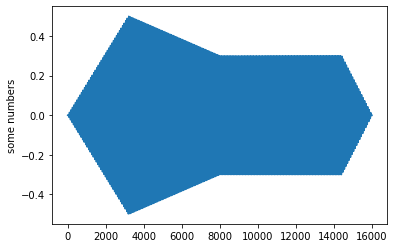

In [81]:

z = envelope(0.5,0.3,0.3,0.1,[0.2,0.3,0.4,0.1], 16000*1)
s = sinusoid(100)
s = am([100,1],2)
s = addsyn(200,1,[0.5,0.2,0.1])
#s = fm([100,23],1,10)
signal = s * z
import matplotlib.pyplot as plt
plt.plot(s*z)
plt.ylabel('some numbers')
plt.show()

In [23]:
def fm(freqs,dur,k):
  carrier = sinusoid(freqs[0],1,16000*dur,1)
  mod = k * sinusoid(freqs[1],1,16000*dur)
  sig = np.cos(carrier + mod)
  return sig

In [ ]:
sig = am([440,10],1,16000,[1,0.4],0)

In [ ]:
sig = fm([440,10],1,16000,[1,20],0)

In [ ]:
z = envelope(0.5,0.3,0.3,0.1,[0.2,0.3,0.4,0.1], 16000)


(16000,)

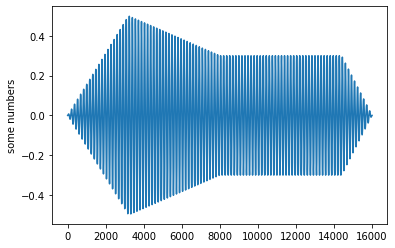

In [36]:

z = envelope(0.5,0.3,0.3,0.1,[0.2,0.3,0.4,0.1], 16000*1)
s = sinusoid(100)
#s = am([100,1],2)
#s = addsyn(200,1,[0.5,0.2,0.1,0.1,0.1])

#s = fm([100,23],1,10)
signal = samples * z
import matplotlib.pyplot as plt
plt.plot(s*z)
plt.ylabel('some numbers')
plt.show()


In [89]:
from scipy.signal import butter, filtfilt
from scipy import signal
import math
from scipy.signal import butter, sosfilt, sosfreqz
import numpy as np

def sinusoid(freq=440.0, dur=1.0, srate=16000, amp=1.0, phase = 0.0): 
    t = np.linspace(0,dur,int(srate*dur))
    data = amp * np.sin(2*np.pi*freq *t+phase)
    return data

def envelope(atk,dcy,susTime,rel, durs, sr):
 env = np.concatenate((np.linspace(0,atk,int(durs[0]*sr//1)), np.linspace(atk,dcy, int(durs[1]*sr//1)), np.linspace(susTime,susTime, int(durs[2]*sr//1)),np.linspace(susTime,0, int(durs[3]*sr//1))),axis = None)
 if env.shape[0] < sr:
   env = np.concatenate((env,np.zeros(sr - env.shape[0])))
 return env

class SynthGen:
  """This class returns a synth"""
  def __init__(self, sr , envelope):
    self.sr = sr
    #self.osc = osc
    self.env = envelope
    
   ######aun hay que arreglar que carge la carga de la señal 
   
  def sinusoid(self, freq = 100, dur=1.0, amp= 1.0, phase = 0.0): 
    t = np.linspace(0,dur,int( self.sr * dur))
    osc = amp * np.sin(2*np.pi* freq * t + phase)
    return osc

  def am(self, c_freq= 100.0, m_freq = 10.0, dur = 1):
    sig = sinusoid(c_freq,dur) * sinusoid(m_freq, dur)
    return sig * self.env

  def fm(self, c_freq = 100, mod_freq = 10, index_mod = 3, dur = 1):
    carrier = sinusoid(c_freq, dur, 1)
    mod = index_mod * sinusoid(mod_freq, dur)
    sig = np.cos(carrier + mod)
    return sig * self.env

  def fm(self, c_freq = 100, mod_freq = 10, index_mod = 3, dur = 1):
    carrier = sinusoid(c_freq, dur, 1)
    mod = index_mod * sinusoid(mod_freq, dur)
    sig = np.cos(carrier + mod)
    return sig * self.env
  
  def additive(self, freq = 100, dur= 1, amplist= []):
    i = 1
    t = np.linspace(0, dur, math.ceil(self.sr * dur))
    ### initialize a new output
    sig = np.zeros(t.size)
    for num in amplist:
        x = np.multiply(sinusoid(freq * i, dur), num)
        ### sum it to the output
        sig = sig + x
        i+=1
    ### making sure the maximum amplitude does not exeed 1
    if np.max(sig)>abs(np.min(sig)):
        sig = sig / np.max(sig)
    else:
        sig = sig / -np.min(sig)
    return sig * self.env
  
  def sustractive(self, lowcut= 800, highcut = 1000):
    
    def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

    def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
            sos = butter_bandpass(lowcut, highcut, fs, order=order)
            y = sosfilt(sos, data)
            return y
        
    num_samples = self.sr
    sig = np.random.rand(num_samples) * 2 - 1
    sig = butter_bandpass_filter(sig, lowcut, highcut, num_samples)
    
    return sig

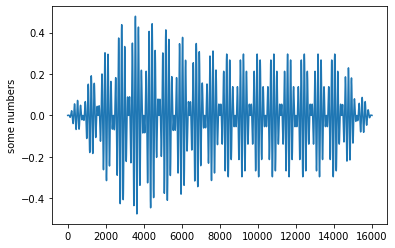

In [90]:
import matplotlib.pyplot as plt

sr = 16000
z = envelope(0.5,0.3,0.3,0.1,[0.2,0.3,0.4,0.1], 16000*1)
synth = SynthGen(sr, z)
s = synth.am()


#z = synth.sustractive()

plt.plot(s)
plt.ylabel('some numbers')
plt.show()

In [97]:
import IPython
IPython.display.display(IPython.display.Audio(AM[1], rate = 16000))


In [125]:
from ipywidgets import HBox, VBox
import ipywidgets as widgets
import librosa
from ipywidgets import TwoByTwoLayout
sr16k = 16000
etiquetas = []


envdict= {'atk': [0,1.], 'dcy': [0,1.], 'susTime': [0,1.], 'rel': [0,1.]}
am_param = {'carrier_freq': [20,8000],'mod_freq':[20,8000]}
AUDIO_LOAD = []
def random_val(val_1, size = 1):
  val = sorted(val_1)
  result = np.random.randint(val[0], val[1], size)[0]
  return result

env = [widgets.FloatSlider(value= 0.5, min=envdict[key][0], max=envdict[key][1], step=0.01, description= key,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout= False,
    readout_format='d',
)for key in envdict.keys()]

envdur = [widgets.FloatSlider(value= 0.5, min=envdict[key][0], max=envdict[key][1], step= 0.01, description= key+'dur',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout= False,
    readout_format='d',
)for key in envdict.keys()]

am = [widgets.IntRangeSlider(value=[4000,8000], min=am_param[key][0], max=am_param[key][1], step= 10, description= key,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)for key in am_param.keys()]

gen = [widgets.BoundedIntText(value=7, min=0, max=10,step=1,description='AMOUNT:',disabled=False),
       widgets.Text(value='Synth', placeholder='Type something', description='group_id:', disabled=False)
]

button = widgets.Button(
    description='Generate',
)

tab1 = HBox(children = [VBox(children= env),
                        VBox(children= envdur),
                        VBox(children= am) ,
                        VBox(children= gen),
                        VBox(children = [button])])
                        
tab2 = HBox(children = [VBox(children= env),VBox(children= env) ,VBox(children= env)])
tab3 = HBox(children = [VBox(children= env),VBox(children= env) ,VBox(children= env)])
tab4 = HBox(children = [VBox(children= env),VBox(children= env) ,VBox(children= env)])


tab2 = VBox(children=[widgets.IntRangeSlider(
    value=[5, 7],
    min=0,
    max=10,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)])

AM = []

@button.on_click
def boton_action(b=None):
  for i in range(gen[0].value):
    ####las envolventes no están por rangos
    norm_envelope = normalize_sum(envdur)
    z = envelope(env[0].value,env[1].value, env[2].value, env[3].value, norm_envelope, 16000 * 1)
    synth = SynthGen(sr, z)
    data = synth.am(random_val(am[0].value),random_val(am[1].value), 1)
    fft = librosa.amplitude_to_db(np.abs(np.fft.fft(data)))
    f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
    #AUDIO_LOAD.append({'gid': text,'id': text+ str(idx), 'trackname': track, 'data': data, 'fft': fft, 'f0': f0})
    AUDIO_LOAD.append({'gid': gen[1].value,'id': gen[1].value + '_' + str(i), 'trackname': gen[1].value + '_' + str(i) + '.wav','data': data, 'fft': fft, 'f0': f0})

tab = widgets.Tab()
tab.children = [tab1,tab2,tab3,tab4]
tab.set_title(0," amplitude mod")
tab.set_title(1,"fm")
tab.set_title(2,"additive")
tab.set_title(3,"sustractive")


tab

In [19]:
def normalize_sum(values):
  env_val = np.array([x.value for x in values])
  env_val = env_val/ env_val.min()
  env_val = env_val/env_val.sum()
  return env_val

z = normalize_sum(env)
z

array([0.19852941, 0.06617647, 0.27205882, 0.46323529])